In [1]:
import json

# json_file = "./rawSoftmax_b_lenet_se_singleThresh_2023-07-19_153525.json"
# FIXME MISSING -> json_file = "../../model-outputs/b_lenet_cifar_singleThresh_2023-07-20_161032.json"
json_file = "../../model-outputs/b_lenet_cifar_singleThresh_2023-07-20_172520.json"

with open(json_file) as json_data:
    data = json.load(json_data)

#data

In [2]:
#%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
# depending on what's installed, might need a different backend
#plt.switch_backend('WebAgg')
from scipy.stats import mstats

In [3]:
# these are the ground truth values
true_vals = data['test_vals']['true_indices']
print(len(true_vals))

10000


In [4]:
num_exits = data['test_vals']['num_exits']
num_compares = len(data['test_vals']['comps'])

# num_exits x num_samples x num_classes

#sftmx = data['test_vals']['comps'][1]['raw_softmax']
#sftmx = np.array(sftmx)
# NOTE NOT BLOODY USED

skipping entropy
not skipping Softmax
not skipping Trunc Base-2 Softmax
not skipping Non-Trunc Base-2 Softmax
not skipping Base-2 Sub-Softmax


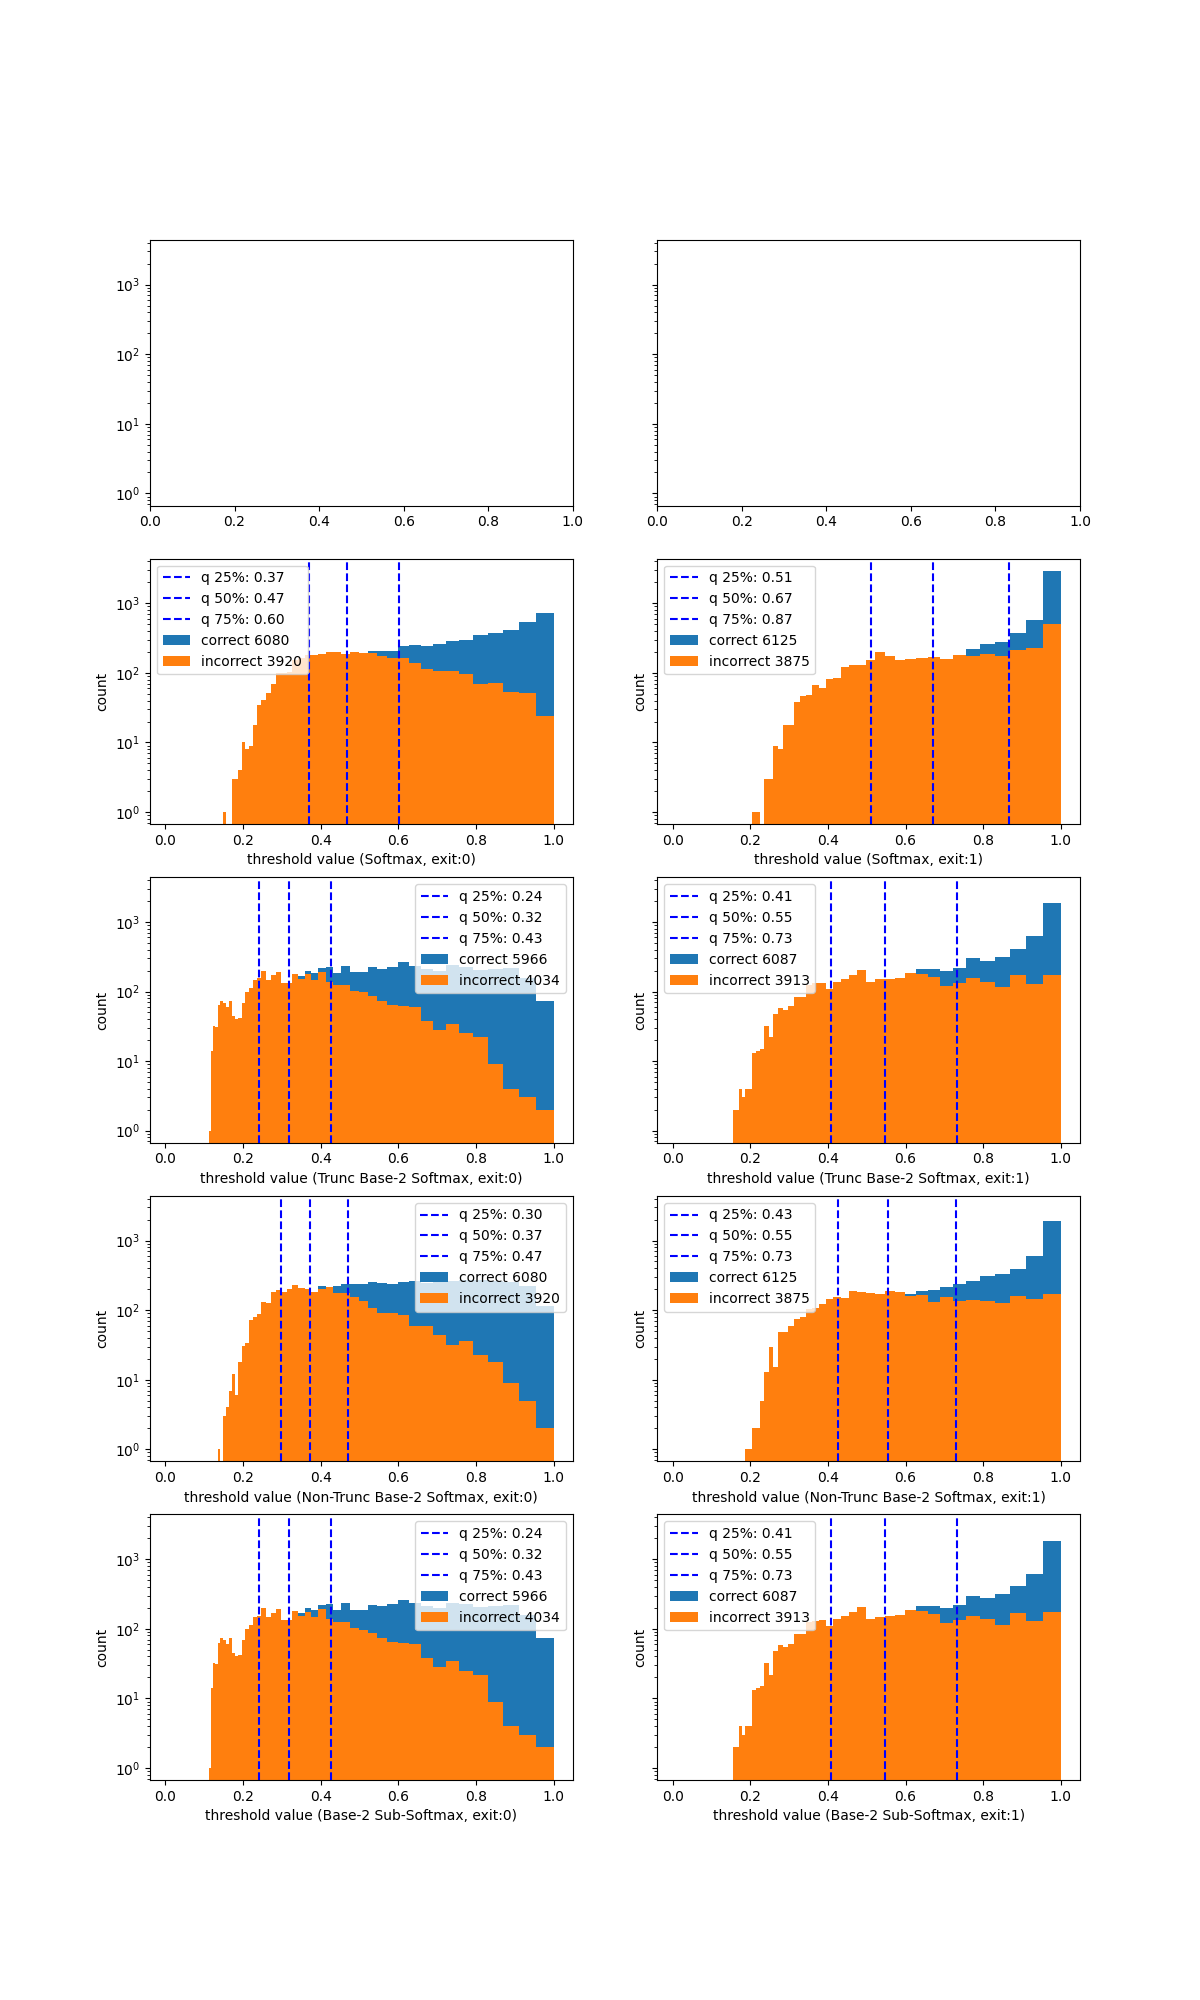

In [5]:
%matplotlib widget

# The short version, we want these plots to be the same or very close.
# This means that the effect of changing base and quantisation will
# have had a minimal effect on the resulting values used to threshold
# the early exit

fig, ax_grp = plt.subplots(nrows=num_compares, ncols=num_exits, sharey=True)

for row, func in enumerate(data['test_vals']['comps']):
    if row == 0:
        # NOTE jthis particular file, entropy results were not recorded correctly?
        # ../../model-outputs/b_lenet_cifar_singleThresh_2023-07-20_172520.json
        # the entropy plot would be different anyway? since the inequality is reversed
        print('skipping entropy')
        continue
    f_name = str(data['test_vals']['comps'][row]['name'])
    print(f'not skipping {f_name}')
    
    raw_softmax_per_exit = np.array(data['test_vals']['comps'][row]['raw_softmax'])
    for exit_num in range(raw_softmax_per_exit.shape[0]):
        #print(f"Exit num:{exit_num}, sfmx dim:{raw_softmax_per_exit[exit_num].shape}")
    
        ax = ax_grp[row][exit_num]
    
        # discern between correctly classified values and not  
        correctness = np.argmax(raw_softmax_per_exit[exit_num], -1) == true_vals
        
        # separate the maximum values for the correct and incorrect
        maxsoftmax = np.max(raw_softmax_per_exit[exit_num], -1)
        
        # NOTE command nukes jupyter vvv unsure why
        correct_vals = maxsoftmax[correctness]
        wrong_vals = maxsoftmax[np.invert(correctness)]
        
        logbins = np.logspace(np.log10(0.01),np.log10(1),100)
        # logbins = np.linspace(0.5, 1, 200)
        
        quants = [0.25, 0.5, 0.75]
        quantiles = mstats.mquantiles(wrong_vals, prob=quants)
        for i, q in enumerate(quantiles):
            ax.axvline(q, 0, color='b', ls='--', label=f"q {quants[i]*100:.0f}%: {q:.02f}")

        ax.hist(correct_vals, bins=logbins, label=f'correct {len(correct_vals)}')      
        ax.hist(wrong_vals, bins=logbins, stacked=True, label=f'incorrect {len(wrong_vals)}')
        ax.set_xlabel(f'threshold value ({f_name}, exit:{exit_num})')
        ax.set_ylabel('count')
        ax.legend()
        
        # NOTE for some reason these cause kernel to hang
        # turns out the old version of plt couldn't handle zero sized bins with log scaling
        ax.set_yscale('log')
        #ax.set_xscale('log')

fig.set_size_inches(6 * num_exits, 4 * num_compares)
plt.show()